In [1]:
#그래프 기본 설정

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'AppleGothic' #applegothic
rcParams['axes.unicode_minus'] = False

In [3]:
import pandas as pd
data = pd.read_csv("/Users/yang-eun-yeol/Desktop/my_quant/데이터/주가리포트.txt", sep = "\t", encoding = "euc-kr")
display(data.head())

,종목명,리포트제목,적정가격,의견,증권사,날짜
0,SK하이닉스,리스크 관리가 좀더 필요한 시점,120000,매수(유지),하이투자증권,2021-10-15
1,솔루엠,수주잔고가 쌓인다,28000,매수(유지),하이투자증권,2021-10-15
2,유한양행,높아진 성공 가능성 할인보다 할증 요소,90000,매수(유지),키움증권,2021-10-15
3,코스모신소재,증설은 곧 성장이다,-,-,키움증권,2021-10-15
4,넷마블,"올해까지 실적으론 고평가, 내년 실적부턴 저평가",145000,매수,이베스트투자증권,2021-10-15


In [4]:
#의견 통일
display(data['의견'].value_counts())
data = data.loc[~data['의견'].isin(['매도', '-', 'Market Under Perform'])]
buy_opinions = ['매수(유지)', "Outperform", "StrongBuy", "강력매수", "신규매수", "단기매수", "적극매수"]
data.loc[data['의견'].isin(buy_opinions), '의견'] = "매수"
data.loc[data['의견'] != "매수", "의견"] = "중립"
display(data['의견'].value_counts(normalize = True))

의견
매수                      10396
매수(유지)                   4120
-                        1725
Hold                      227
OutPerform                144
중립                        141
MarketPerform              39
Neutral                    36
StrongBuy                  12
강력매수                       10
시장수익률                       2
신규매수                        2
보유                          2
적극매수                        1
매도                          1
단기매수                        1
Market Under Perform        1
Name: count, dtype: int64

의견
매수    0.960946
중립    0.039054
Name: proportion, dtype: float64

In [7]:
#숫자로 표현
import numpy as np
def filtering_numeric(value):
    if type(value) == float:
        return value
    else:
        output = ''
        for s in value:
            if s.isnumeric():
                output += s
        if len(output) == 0:
            return np.nan
        else:
            return int(output)
print(filtering_numeric('12345'))
print(filtering_numeric('없음'))
print(filtering_numeric('12345원'))
data['적정가격'] = data['적정가격'].apply(filtering_numeric)
data.dropna(inplace = True)

12345
nan
12345


In [11]:
#주가 부착

import os 
sp_data_dict = dict()
path = "/Users/yang-eun-yeol/Desktop/my_quant/데이터/주가데이터/" #주가데이터로 경로설정
for stock_name in data['종목명'].unique():
    if stock_name + ".csv" in os.listdir(path):
        sp_data = pd.read_csv(path + stock_name + ".csv", parse_dates = ['Date'])
        sp_data_dict[stock_name] = sp_data
    else:
        data = data.loc[data['종목명'] != stock_name]
def find_stock_price(stock_name, date, direction = "past"):    
    stock_data = sp_data_dict[stock_name]
    if (direction == "past") and (stock_data['Date'].min() > date):
        return np.nan    
    elif (direction == "future") and (stock_data['Date'].max() < date):
        return np.nan 
    else:
        while True:
            if sum(stock_data['Date'] == date) > 0: 
                value = stock_data.loc[stock_data['Date'] == date, 'Close'].iloc[0]  
                break
            else:
                if direction == "past":
                    date -= pd.to_timedelta(1, 'D')
                else:
                    date += pd.to_timedelta(1, 'D')
        return value
data["날짜"] = pd.to_datetime(data["날짜"])
sp_col = []
for idx, row in data.iterrows():
    value = find_stock_price(row["종목명"], row["날짜"], direction = "past")
    sp_col.append(value)
data["주가"] = sp_col

count    1111.000
mean       47.741
std       100.220
min       -88.664
25%        23.944
50%        33.333
75%        45.304
max      1154.480
dtype: float64

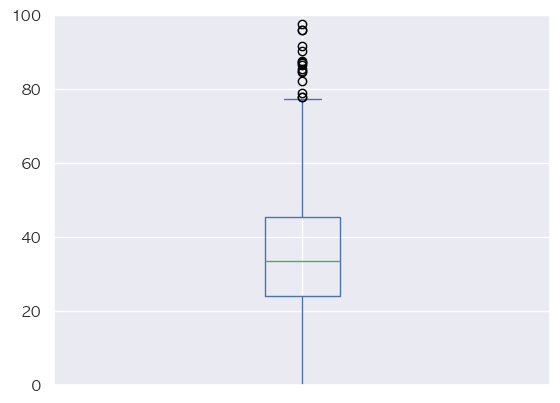

In [14]:
#적정 주가와 현재가의 차이
temp = (data['적정가격'] - data['주가']) / data['주가'] * 100
temp.plot(kind = "box", ylim = (0, 100))
display(temp.describe().round(3))

In [16]:
display(data.iloc[temp.argmax()])
display(data.iloc[temp.argmin()])
data = data.loc[~data['종목명'].isin(['삼성전자', '대한해운'])]
data = data[data['적정가격'] > 0]

종목명                       KT
리포트제목       미디어/콘텐츠가 견인한 호실적
적정가격                350000.0
의견                        매수
증권사                     SK증권
날짜       2019-05-07 00:00:00
주가                     27900
Name: 7898, dtype: object

종목명                     KT&G
리포트제목       내수담배 수요회복이 실적 견인
적정가격                 14000.0
의견                        매수
증권사                     SK증권
날짜       2016-07-22 00:00:00
주가                    123500
Name: 16230, dtype: object

In [18]:
#기대 수익률 계산
def calc_ror_based_on_report(report_data, D):
    cur_sp_list = report_data['주가'].values
    fut_date_list = (report_data['날짜'] + pd.to_timedelta(D, "D")).values
    fut_sp_list = []
    for stock_name, fut_date in zip(report_data['종목명'], fut_date_list):
        fut_sp = find_stock_price(stock_name, fut_date, "future")
        fut_sp_list.append(fut_sp)
    fut_sp_list = np.array(fut_sp_list)
    ror_list = (fut_sp_list - cur_sp_list) / cur_sp_list * 100
    ror_list = ror_list[~np.isnan(ror_list)]
    return ror_list
buy_data = data.loc[data['의견'] == "매수"]
hold_data = data.loc[data['의견'] == "중립"]
buy_3M_ror_list = calc_ror_based_on_report(buy_data, 90)
hold_3M_ror_list = calc_ror_based_on_report(hold_data, 90)
buy_6M_ror_list = calc_ror_based_on_report(buy_data, 180)
hold_6M_ror_list = calc_ror_based_on_report(hold_data, 180)
buy_1Y_ror_list = calc_ror_based_on_report(buy_data, 365)
hold_1Y_ror_list = calc_ror_based_on_report(hold_data, 365)

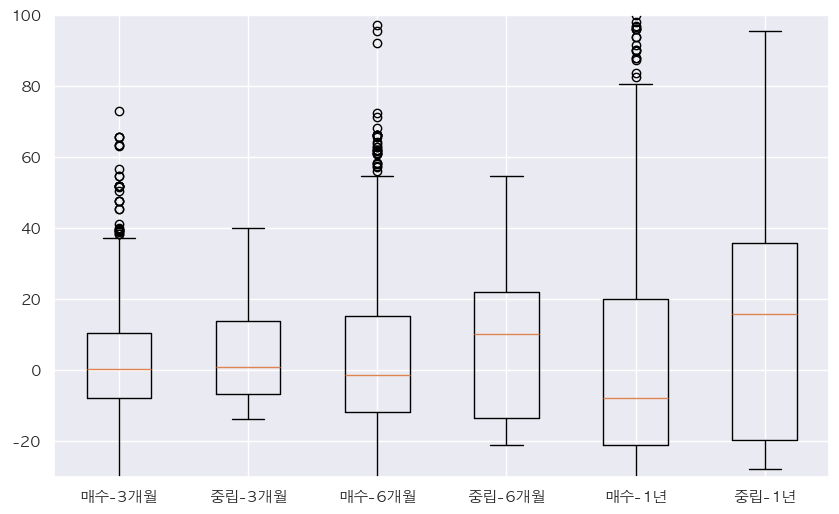

In [19]:
#시각화

#박스플롯
plt.figure(figsize = (10, 6))
plt.boxplot([buy_3M_ror_list, hold_3M_ror_list,
             buy_6M_ror_list, hold_6M_ror_list,
             buy_1Y_ror_list, hold_1Y_ror_list])
plt.ylim(-30, 100)
plt.xticks(range(1, 7), ['매수-3개월', '중립-3개월',
                         '매수-6개월', '중립-6개월',
                         '매수-1년', '중립-1년'])
plt.show()


In [20]:
#통계량 계산

result = pd.concat([pd.Series(buy_3M_ror_list).describe(),
                    pd.Series(hold_3M_ror_list).describe(),
                    pd.Series(buy_6M_ror_list).describe(),
                    pd.Series(hold_6M_ror_list).describe(),
                    pd.Series(buy_1Y_ror_list).describe(),
                    pd.Series(hold_1Y_ror_list).describe()],
                   axis = 1)

result.columns = ['매수-3개월', '중립-3개월', '매수-6개월', '중립-6개월', '매수-1년', '중립-1년']
display(result.round(2))

,매수-3개월,중립-3개월,매수-6개월,중립-6개월,매수-1년,중립-1년
count,1040.00,26.00,980.00,23.00,849.00,17.00
mean,1.99,4.57,2.90,9.19,3.09,24.45
std,15.96,14.43,23.92,23.19,38.63,66.89
min,-53.81,-13.73,-50.91,-21.01,-63.98,-27.82
25%,-7.79,-6.62,-11.78,-13.37,-21.17,-19.68
50%,0.38,0.94,-1.37,10.11,-7.79,15.76
75%,10.45,13.77,15.33,22.00,20.05,35.80
max,73.00,39.92,115.78,54.55,250.00,250.00


In [23]:
#현재가와 적정가의 차이 계산

data['적정증가율'] = (data['적정가격'] - data['주가']) / data['주가'] * 100
data = data.loc[data['적정증가율'] > 0]
def assign_group(inc):
    if inc >= 100:
        return "100%이상"
    elif inc >= 80:
        return "80-100%"
    elif inc >= 60:
        return "60-80%"
    elif inc>= 40:
        return "40-60%"
    elif inc>=20:
        return "20-40%"
    else:
        return "0-20%"
data['적정증가율_그룹'] = data['적정증가율'].apply(assign_group)
display(data['적정증가율_그룹'].value_counts())

적정증가율_그룹
20-40%     518
40-60%     292
0-20%      140
60-80%      58
100%이상      38
80-100%     13
Name: count, dtype: int64

In [24]:
#현재가에서 적정가까지 얼마나 시간이 걸릴 것 인지

def cal_time_to_price(stock_name, date, price):
    stock_data = sp_data_dict[stock_name]
    cond = (stock_data['Date'] >= date) & (stock_data['Close'] >= price)
    if sum(cond) > 0:
        target_date = stock_data.loc[cond, 'Date'].iloc[0]
        return (target_date - date).days
    else:
        return np.nan
value_list = []
for idx, row in data.iterrows():
    value = cal_time_to_price(row["종목명"], row["날짜"], row["적정가격"])
    value_list.append(value)
data["적정가격_도달시간"] = value_list

In [26]:
#적정가까지 얼마만큼의 종목이 도달했는지

A = data["날짜"] < pd.to_datetime("2021-06-30")
B = data["적정가격_도달시간"].notnull()
print("3개월 이전: {}".format(round(sum(A&B) / sum(A),3)))

A = data["날짜"] < pd.to_datetime("2021-03-31")
B = data["적정가격_도달시간"].notnull()
print("6개월 이전: {}".format(round(sum(A&B) / sum(A),3)))

A = data["날짜"] < pd.to_datetime("2020-09-30")
B = data["적정가격_도달시간"].notnull()
print("1년 이전: {}".format(round(sum(A&B) / sum(A),3)))

3개월 이전: 0.432
6개월 이전: 0.447
1년 이전: 0.429


In [28]:
#적정가까지 걸린 시간분포
data.dropna(inplace = True)
display(data['적정가격_도달시간'].describe().astype(int))
display(data.groupby(['적정증가율_그룹'])['적정가격_도달시간'].describe().round(2))

count     441
mean      362
std       388
min         2
25%        95
50%       197
75%       517
max      1838
Name: 적정가격_도달시간, dtype: int64

,count,mean,std,min,25%,50%,75%,max
적정증가율_그룹,,,,,,,,
0-20%,84.0,173.10,241.83,2.0,32.5,82.0,186.0,1302.0
100%이상,1.0,243.00,NaN,243.0,243.0,243.0,243.0,243.0
20-40%,235.0,335.95,349.20,13.0,102.0,190.0,448.5,1823.0
40-60%,103.0,578.40,487.60,24.0,202.5,416.0,862.5,1838.0
60-80%,13.0,402.69,253.91,66.0,255.0,382.0,491.0,903.0
80-100%,5.0,288.60,134.88,178.0,183.0,262.0,312.0,508.0


In [33]:
#기업평가

import warnings
warnings.filterwarnings("ignore") #경고표시 제거


#그래프 설정
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Applegothic'
rcParams['axes.unicode_minus'] = False 

#데이터 준비
import pandas as pd
data = pd.read_csv("/Users/yang-eun-yeol/Desktop/my_quant/데이터/기업월별평점.csv", encoding = "euc-kr") 
display(data.head())

data[['연도', '월']] = data['날짜'].str.split('. ', expand = True).astype(int)

,기업,날짜,전체평점,승진기회및가능성,복지및급여,업무와삶의균형,사내문화,경영진
0,CJ제일제당,2014. 04,3.400000,3.733333,3.066667,2.333333,3.400000,3.000000
1,CJ제일제당,2014. 05,3.200000,3.300000,2.800000,3.000000,3.400000,2.900000
2,CJ제일제당,2014. 06,2.913043,3.130435,2.913043,2.260870,3.173913,2.608696
3,CJ제일제당,2014. 07,3.058824,3.352941,2.470588,2.235294,3.294118,2.764706
4,CJ제일제당,2014. 08,2.800000,3.400000,2.800000,2.400000,3.000000,2.800000


In [55]:
#주가 / 데이터 합치기

import numpy as np
import os

path = "/Users/yang-eun-yeol/Desktop/my_quant/데이터/주가데이터/"

total_M_sp_data = pd.DataFrame()
for stock_name in data['기업'].unique():
    # 주가 데이터 불러오기 
    if stock_name + ".csv" in os.listdir(path):
        sp_data = pd.read_csv(path + stock_name + ".csv", parse_dates = ["Date"])
    else:
        data = data.loc[data['기업'] != stock_name]
        continue
    
    # 연도와 월 추출
    sp_data["연도"] = sp_data["Date"].dt.year
    sp_data["월"] = sp_data["Date"].dt.month
    
    # 월별 평균가격, 월말가격 계산
    M_sp_data = sp_data.groupby(['연도', '월'])['Close'].agg([np.mean,
                                                              lambda x:x.iloc[-1]])
    M_sp_data.reset_index(inplace = True)
    M_sp_data.columns = ["연도", "월", "평균가격", "월말가격"]
    M_sp_data["차월말가격"] = np.nan
    M_sp_data["차월말가격"].iloc[:-1] = M_sp_data["월말가격"].values[1:]
    M_sp_data["기업"] = stock_name

    # 데이터 병합
    total_M_sp_data = pd.concat([total_M_sp_data, M_sp_data],
                                axis = 0, ignore_index = True)

data = pd.merge(total_M_sp_data, data, on = ["연도", "월", "기업"])
display(data.head())

,연도,월,평균가격,월말가격,차월말가격,기업,평균가격_x,월말가격_x,차월말가격_x,평균가격_y,월말가격_y,차월말가격_y,날짜,전체평점,승진기회및가능성,복지및급여,업무와삶의균형,사내문화,경영진
0,2014,4,31479.545455,32800,30400.0,KT,31479.545455,32800,30400.0,31479.545455,32800,30400.0,2014. 04,3.341463,3.170732,2.707317,3.878049,3.195122,2.414634
1,2014,5,31894.736842,30400,30550.0,KT,31894.736842,30400,30550.0,31894.736842,30400,30550.0,2014. 05,2.884615,2.576923,2.634615,3.403846,2.826923,1.961538
2,2014,6,30126.315789,30550,33300.0,KT,30126.315789,30550,33300.0,30126.315789,30550,33300.0,2014. 06,2.584615,2.184615,2.230769,3.476923,2.784615,1.738462
3,2014,7,30667.391304,33300,35000.0,KT,30667.391304,33300,35000.0,30667.391304,33300,35000.0,2014. 07,2.900000,2.400000,2.550000,3.250000,2.850000,1.800000
4,2014,8,34220.000000,35000,34300.0,KT,34220.000000,35000,34300.0,34220.000000,35000,34300.0,2014. 08,2.769231,2.692308,2.153846,3.153846,2.615385,1.769231


In [57]:
#월별 평점 / 평균 가격의 상관관계
corr_result = []
cols = ["전체평점", "승진기회및가능성", "복지및급여", "업무와삶의균형", "사내문화", "경영진"]
numeric_data = data.select_dtypes(include='number')

for corp in data['기업'].unique():
    corp_data = numeric_data.loc[data['기업'] == corp]
    record = corp_data.corr().loc['평균가격', cols].values
    corr_result.append(record)

corr_result = pd.DataFrame(corr_result, columns=cols)



In [61]:
#수익 비교

def make_group(rating):
    if rating <= 3.0:
        return 1
    elif rating <= 3.3:
        return 2
    elif rating <= 3.5:
        return 3
    elif rating <= 4.0:
        return 4
    else:
        return 5
data['수익률'] = (data['차월말가격'] - data['월말가격']) / data['월말가격'] * 100
data.dropna(inplace = True)
def calc_ror_using_eqw_str(data, r_col): 
    group_list = data[r_col].apply(make_group)
    ym_list = data[['연도', '월']].sort_values(['연도', '월']).drop_duplicates().values
    result = []
    for year, month in ym_list:
        ym_data = data.loc[(data["연도"] == year) & (data["월"] == month)]
        for group in range(1, 6):
            group_data = ym_data.loc[group_list == group]
            if len(group_data) == 0:
                result.append([year, month, group, 0])
            else:
                ror_list = group_data['수익률']
                inve_per_stock = 10**8 / len(ror_list)
                profit = (inve_per_stock * ror_list / 100).sum()
                profit_ratio = profit / 10 ** 8 * 100
                result.append([year, month, group, profit_ratio])

    result = pd.DataFrame(result, columns = ["연도", "월", "그룹", "수익률"])
    return result
def visualize_result(result):
    ym_list = result[['연도', '월']].sort_values(['연도', '월']).drop_duplicates().values
    plt.figure(figsize = (14, 5))
    for group in range(1, 6):
        plt.plot(result.loc[result['그룹'] == group, '수익률'].values, label = group)
    xticks_range = np.arange(0, len(ym_list), 12)
    plt.xticks(xticks_range, ym_list[xticks_range, 0])
    plt.ylabel("수익률")
    plt.legend()

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,1.139,5.644,-13.910,-1.089,0.0,2.902,22.592
2,89.0,0.929,4.799,-9.959,0.000,0.0,2.517,16.708
3,89.0,0.165,4.959,-14.853,-1.378,0.0,1.565,13.750
4,89.0,0.678,6.820,-14.573,-3.306,0.0,4.881,22.034
5,89.0,0.521,5.502,-20.155,-1.679,0.0,2.170,19.015


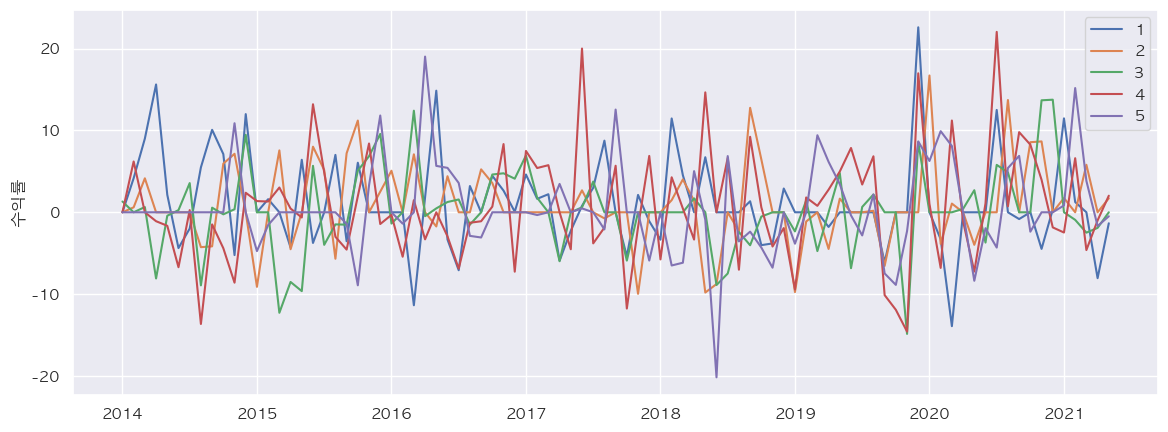

In [64]:
r_col = "전체평점"
result = calc_ror_using_eqw_str(data, r_col)
visualize_result(result)
display(result.groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,1.296,5.674,-16.946,-1.771,0.812,3.429,17.104
2,89.0,-0.032,4.758,-12.283,-2.369,0.000,1.312,18.142
3,89.0,-0.169,6.679,-17.508,-3.082,0.000,1.307,28.177
4,89.0,0.820,6.675,-20.155,-2.192,0.000,3.832,21.053
5,89.0,-0.238,1.941,-10.532,0.000,0.000,0.000,8.657


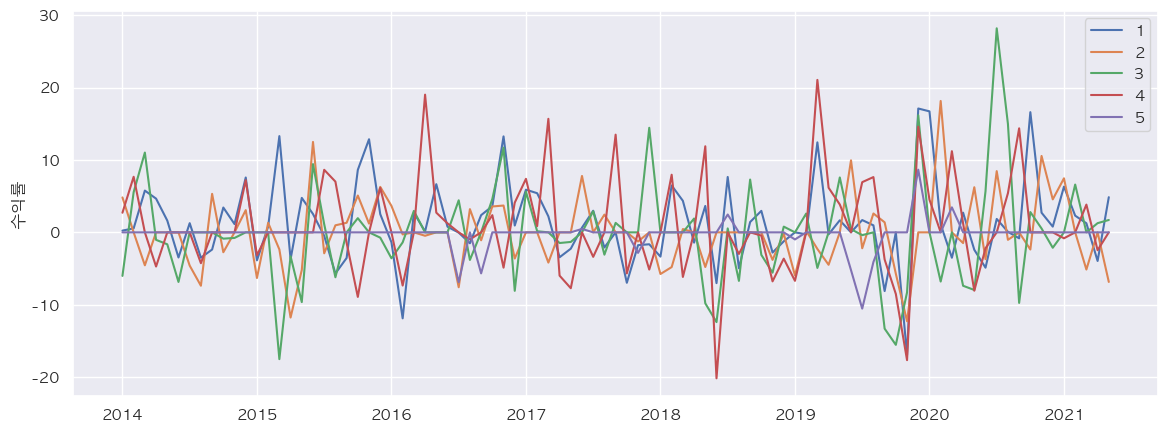

In [65]:
#세분화
#승진

r_col = "승진기회및가능성"
result = calc_ror_using_eqw_str(data, r_col)
visualize_result(result)
display(result.groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,0.683,6.273,-12.760,-2.508,0.000,1.645,26.716
2,89.0,0.124,4.034,-16.946,0.000,0.000,0.000,12.809
3,89.0,0.004,5.940,-18.471,-0.190,0.000,0.000,31.319
4,89.0,0.928,7.164,-17.647,-4.070,0.493,3.881,29.314
5,89.0,0.885,5.915,-20.155,-1.946,0.000,3.811,19.015


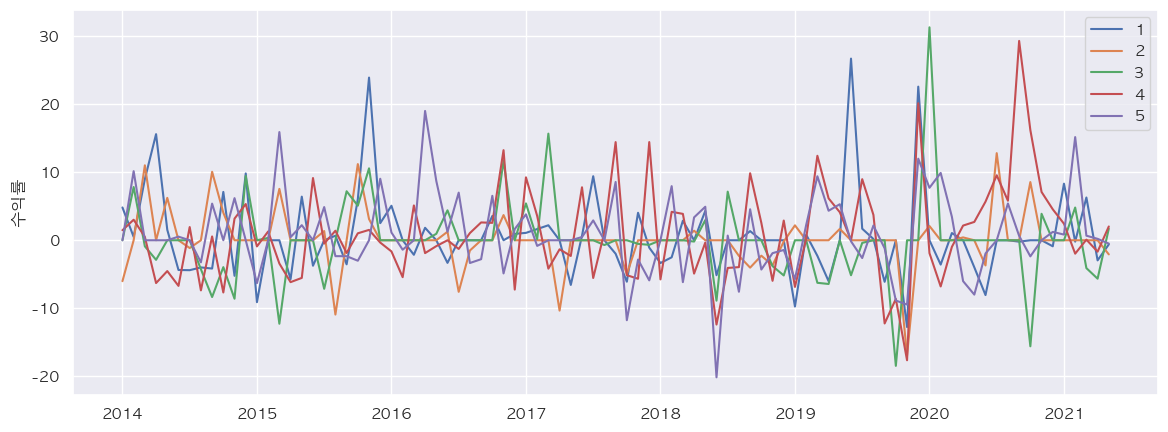

In [67]:
#복지 /급여

r_col = "복지및급여"
result = calc_ror_using_eqw_str(data, r_col)
visualize_result(result)
display(result.groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,0.682,6.260,-18.471,-2.319,0.000,2.781,22.592
2,89.0,0.218,5.828,-17.508,-0.959,0.000,0.533,31.319
3,89.0,0.068,5.272,-11.617,-1.370,0.000,1.062,15.172
4,89.0,0.828,6.568,-11.572,-2.452,0.223,4.378,23.924
5,89.0,0.500,5.056,-20.042,0.000,0.000,0.000,21.757


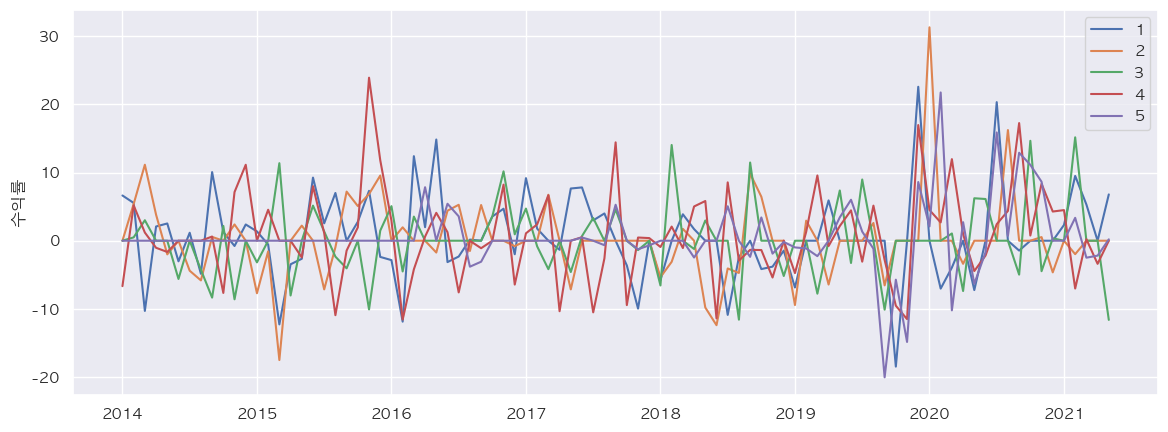

In [68]:
#워라밸

r_col = "업무와삶의균형"
result = calc_ror_using_eqw_str(data, r_col)
visualize_result(result)
display(result.groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,0.579,6.295,-13.910,-3.103,0.748,3.589,15.580
2,89.0,-0.978,5.782,-17.647,-3.975,0.000,0.420,14.325
3,89.0,0.524,6.487,-17.508,-0.610,0.000,0.154,28.177
4,89.0,1.070,7.349,-20.155,-2.337,0.000,4.597,31.319
5,89.0,1.687,7.413,-15.595,0.000,0.000,0.474,29.314


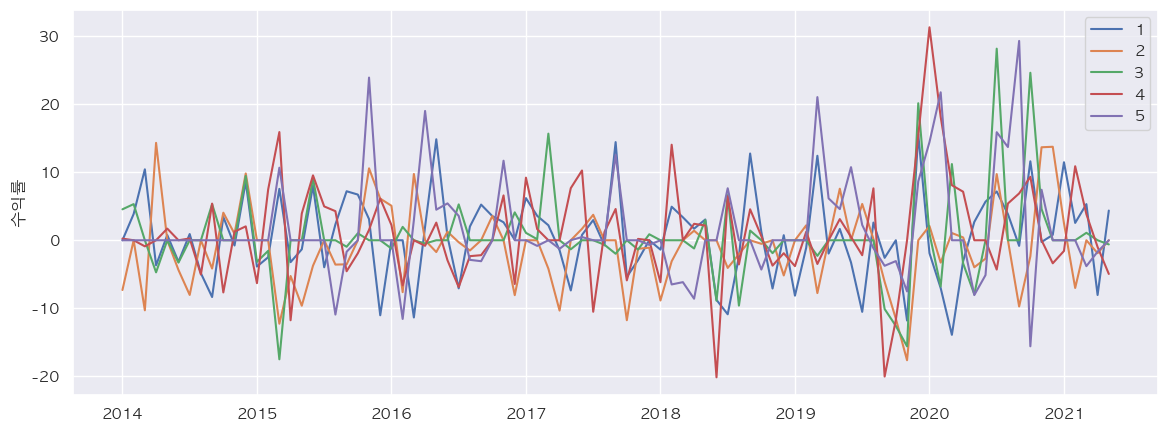

In [69]:
#사내문화

r_col = "사내문화"
result = calc_ror_using_eqw_str(data, r_col)
visualize_result(result)
display(result.groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,0.569,5.270,-15.535,-2.603,0.871,3.557,17.104
2,89.0,0.583,4.492,-11.538,0.000,0.000,0.000,18.142
3,89.0,0.648,5.778,-20.155,0.000,0.000,0.834,23.289
4,89.0,0.137,4.382,-11.898,0.000,0.000,0.000,22.875
5,89.0,0.124,1.652,-5.664,0.000,0.000,0.000,8.657


,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,0.569,5.270,-15.535,-2.603,0.871,3.557,17.104
2,89.0,0.583,4.492,-11.538,0.000,0.000,0.000,18.142
3,89.0,0.648,5.778,-20.155,0.000,0.000,0.834,23.289
4,89.0,0.137,4.382,-11.898,0.000,0.000,0.000,22.875
5,89.0,0.124,1.652,-5.664,0.000,0.000,0.000,8.657


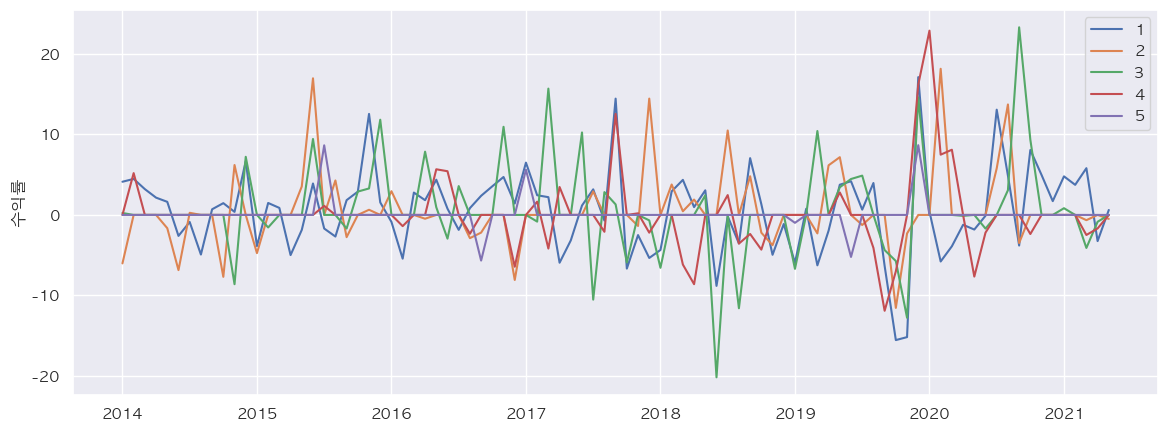

In [70]:
#경영진

r_col = "경영진"
result = calc_ror_using_eqw_str(data, r_col)
visualize_result(result)
display(result.dropna().groupby('그룹')['수익률'].describe().round(3))
display(result.groupby('그룹')['수익률'].describe().round(3))